In [115]:
import os
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.signal import fftconvolve, hilbert
import random
import math
import re

In [64]:
def get_files_in_folder(folder_path):
    try:
        data_files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        for file_path in data_files:
            if ".csv" not in file_path:
                data_files.remove(file_path)
        return data_files

    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []

def get_indices_of_min_max(csp):
    #maxima = np.where((csp[1:-1] > csp[0:-2]) * (csp[1:-1] > csp[2:]))[0] + 1
    #minima = np.where((csp[1:-1] < csp[0:-2]) * (csp[1:-1] < csp[2:]))[0] + 1

    minima, maxima = [], []
    buff = []
    dx = csp[1:] - csp[0:-1]
    for i in range(1, len(dx)):
        if dx[i-1] > 0 and dx[i] <= 0:
            maxima.append(i)
        elif dx[i-1] < 0 and dx[i] >= 0:
            minima.append(i)
    return np.array(maxima), np.array(minima)

def zNormalize_csp(csp):
    return (csp - np.mean(csp)) / np.std(csp)

def LoG(x, sigma):
    return ((x**2 - sigma**2) / sigma**4 ) * np.exp(-x**2/(2 * sigma**2))

def LoG_discrete(sigma, n):
    """
    n : odd integer
    """
    l = np.zeros(n)
    for i in range(n):
        x_i = i - (n - 1) / 2
        l[i] = LoG(x_i, sigma)
    return l

def segmentize_csp(csp, seperation_max, n, sigma, threshold):
    """
    signal : Time signal as array
    seperation_max : Max distance between two related points
    n : LoG kernel size
    sigma : Accuracy finding peaks
    threshold : Minimum amplitude for selecting events

    """
    kernel = LoG_discrete(sigma, n)
    signal_LoG = fftconvolve(csp, kernel)[int(n):-int(n)] #* (sigma ** 2)

    # Find regions of
    ds = signal_LoG[1:] - signal_LoG[:-1]
    shifts_idx = np.where(ds < -threshold)[0]
    roi_idx = np.where(np.abs(shifts_idx[1:] - shifts_idx[:-1]) > seperation_max)[0].astype('int64')
    roi_idx = [el + 1 for el in roi_idx]
    roi = np.split(shifts_idx, roi_idx)     # Regions of interest

    # Reduce calculation time -> Remove direct neighbouring points
    for i, region in enumerate(roi):
        dr = region[1:-1] - region[:-2]
        reg_idx = np.where(dr < 1)[0]
        reg_idx = [el + 1 for el in reg_idx]
        roi[i] = np.delete(region, reg_idx)


    fig, ax = plt.subplots(nrows=2,ncols=1)
    ax[0].plot(csp, label='Raw CSP', color='k', lw=1)
    for region_idx in roi:
        ax[0].scatter(region_idx, csp[region_idx], s=20)

    ax[1].plot(signal_LoG, label='LoG of CSP')
    ax[1].set_xlabel('Timestep')
    #ax[1].set_ylim([-1, 1])
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    return roi


In [62]:
# Set transformation for speed and steering angle
offsets_dict, scales_dict = {"Speed (m/s)": 105}, {"Speed (m/s)": 4}
offsets_dict["Steering angle (deg)"] = 150
scales_dict["Steering angle (deg)"] = 1

# Get files
parentFolder = 'results/synthetic_lanechangecitos'
data_files = get_files_in_folder(folder_path=parentFolder)
data_files.sort()
data_files.reverse()


1.9895196601282805e-17


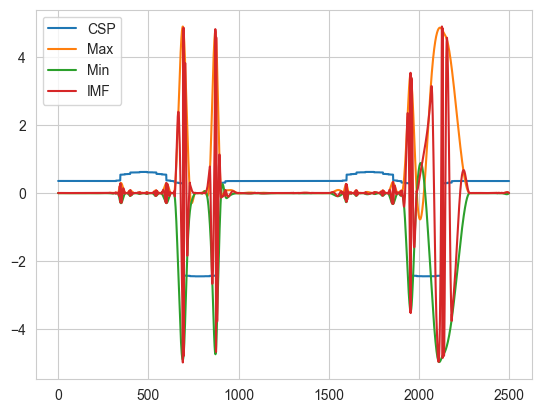

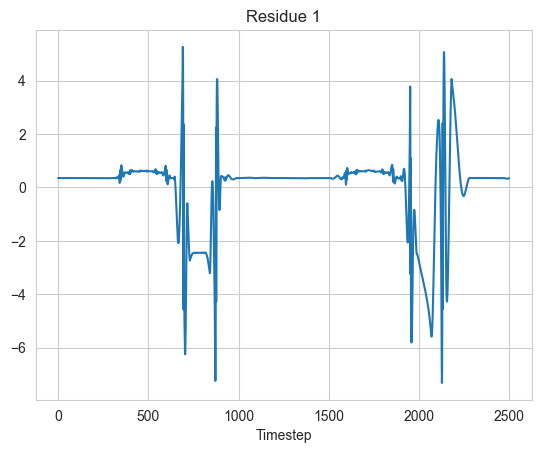

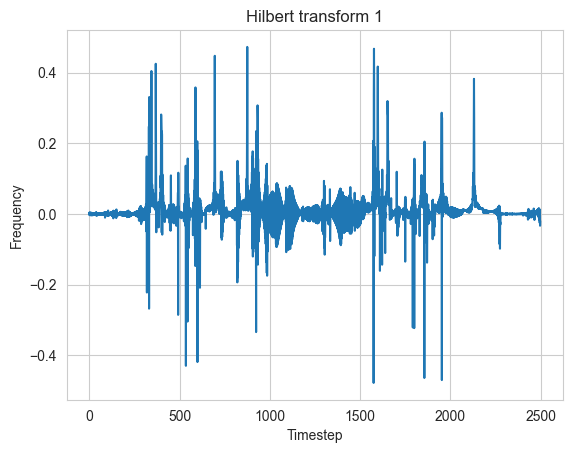

1.1368683772161604e-17


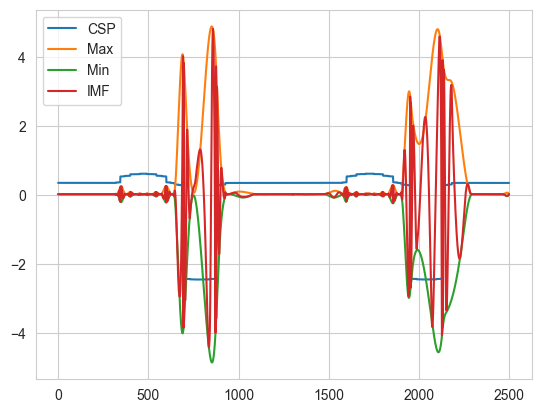

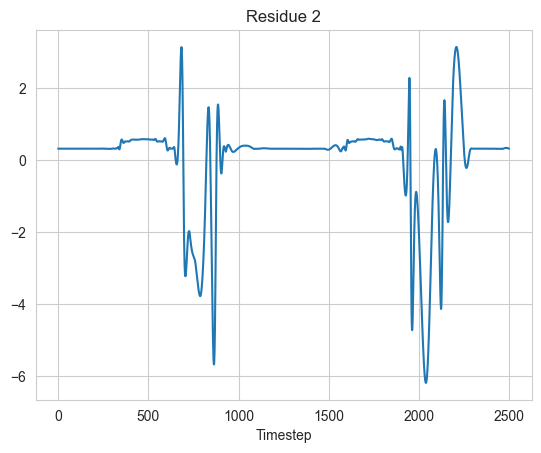

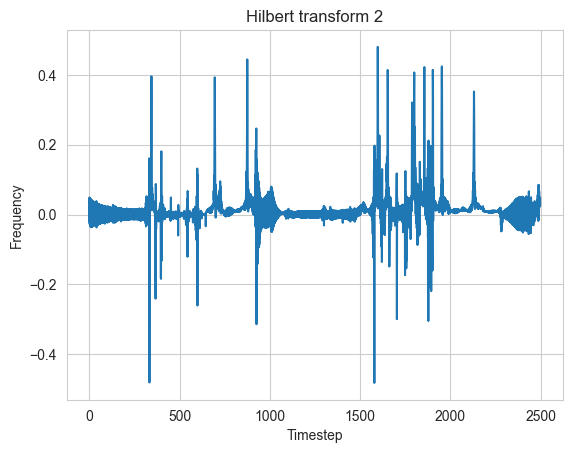

4.263256414560601e-18


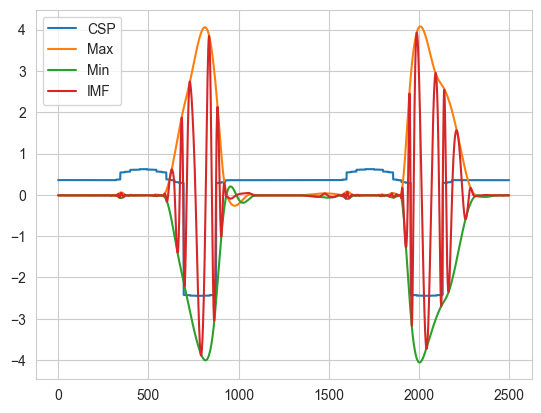

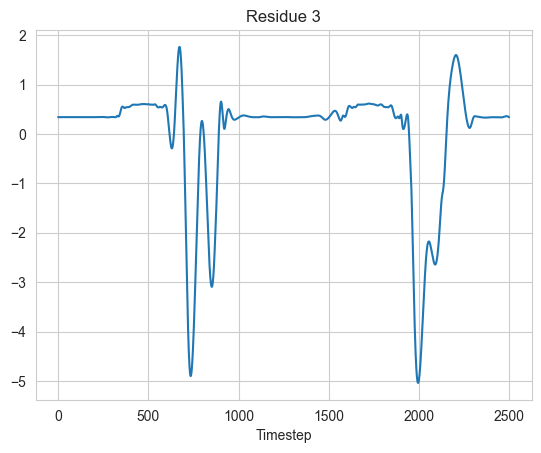

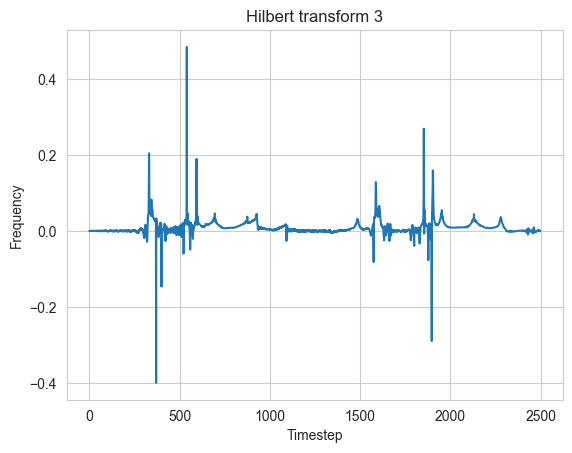

0.0


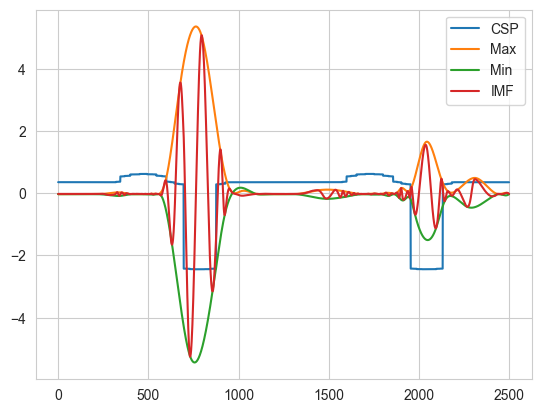

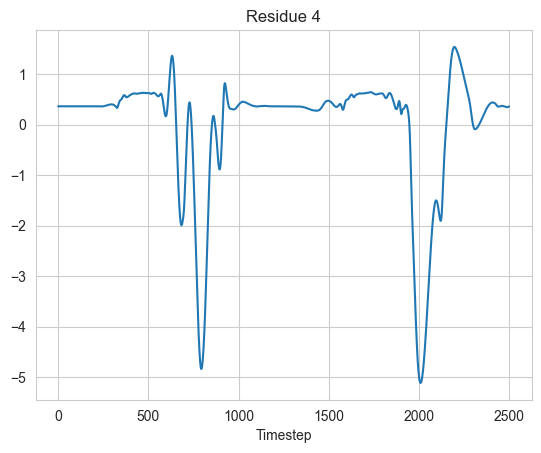

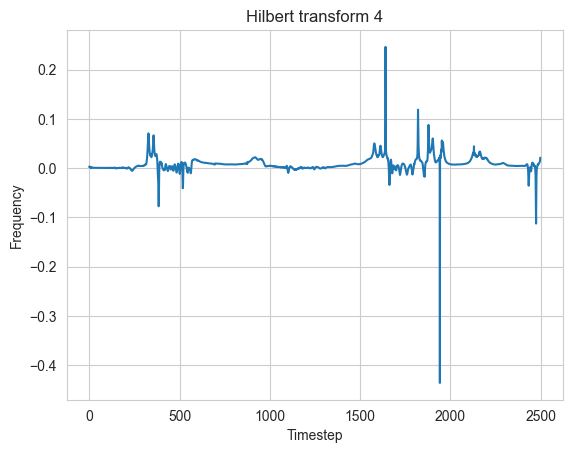

1.1368683772161604e-17


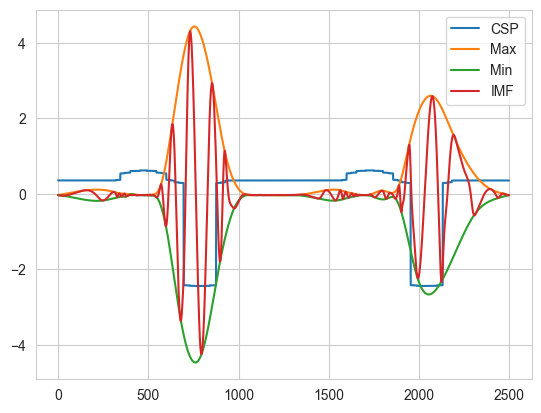

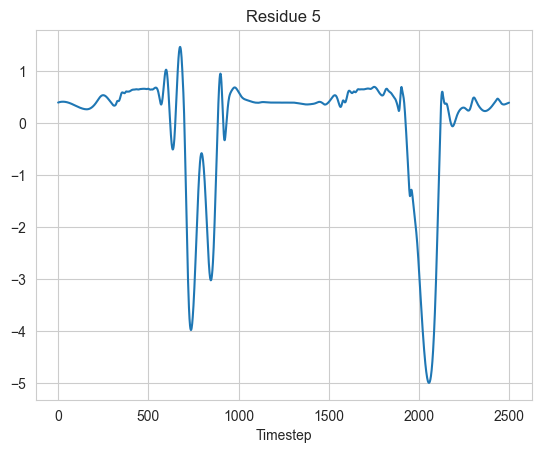

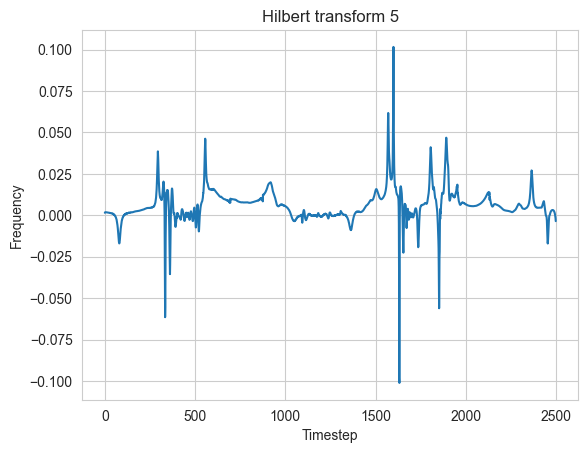

In [135]:
file_path = data_files[0]
data = pd.read_csv(file_path, sep=";")
csp = np.array_split(data.loc[data['Lane change'] == 1]['Morton_Index'].to_numpy().astype('float64'), 2)[0]
csp = data['Morton_Index'].to_numpy().astype('float64')
timestamps = np.arange(len(csp))
#changepoints_idx = segmentize_csp(csp, 50, 25, 2, 1)
#changepoints_idx = np.asarray(changepoints_idx, dtype="object")
#changepoints_idx = np.concatenate(changepoints_idx, axis=0)

csp = zNormalize_csp(csp)
csp_approx = np.copy(csp)

#fitting_points = np.ones(len(csp)) * np.nan
#fitting_points[changepoints_idx] = csp_approx[changepoints_idx]
#fitting_points = np.ma.array(fitting_points, mask=np.isnan(fitting_points))
n_iterations = 5

residues = np.zeros((n_iterations+1, len(csp)))
residues[0,:] = csp_approx

imfs = np.zeros((n_iterations, len(csp)))
IA = np.zeros((n_iterations, len(csp)))
IF = np.zeros((n_iterations, len(csp)-1))
IP = np.zeros((n_iterations, len(csp)))

for k in range(n_iterations):
    for i in range(15):

        #max_idx, min_idx = get_indices_of_min_max(fitting_points)
        #csp_max = fitting_points[max_idx]
        #csp_min = fitting_points[min_idx]

        # Get all maxima and minima
        max_idx, min_idx = get_indices_of_min_max(csp_approx)

        # Reduce end-point aliasing
        max_idx = np.insert(max_idx, 0, 0)
        max_idx = np.append(max_idx, len(csp_approx)-1)
        min_idx = np.insert(min_idx, 0, 0)
        min_idx = np.append(min_idx, len(csp_approx)-1)

        # Points to fit upper and lower envelope
        csp_max = csp_approx[max_idx]
        csp_min = csp_approx[min_idx]

        max_fit = CubicSpline(max_idx, csp_max)
        min_fit = CubicSpline(min_idx, csp_min)
        middle = (max_fit(timestamps) + min_fit(timestamps)) / 2

        # Guess of IMF
        csp_approx = csp_approx - middle
        csp_approx = zNormalize_csp(csp_approx)

    print(np.mean(csp_approx))

    # Compute Hilbert transform
    fs = 1
    analytic_signal = hilbert(csp_approx)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs
    IA[k, :] = amplitude_envelope
    IF[k, :] = instantaneous_frequency
    IP[k, :] = instantaneous_phase

    # Save residue
    residues[k+1, :] = residues[k, :] - csp_approx
    imfs[k, :] = csp_approx

    fig, ax = plt.subplots()
    ax.plot(csp, label="CSP")
    ax.plot(timestamps, max_fit(timestamps), label="Max")
    ax.plot(timestamps, min_fit(timestamps), label="Min")
    ax.plot(timestamps, csp_approx, label="IMF")
    #ax.set_ylim([])
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(residues[k+1])
    ax.set_title('Residue ' + str(k+1))
    ax.set_xlabel('Timestep')

    plt.show()

    fig, ax = plt.subplots()
    ax.plot(instantaneous_frequency)
    ax.set_title('Hilbert transform ' + str(k+1))
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Timestep')

    plt.show()

    #
    csp_approx = residues[k+1]



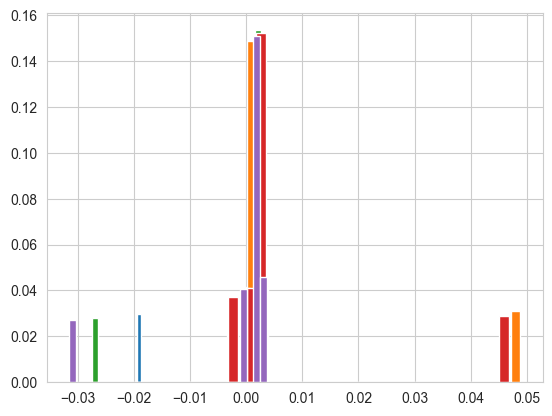

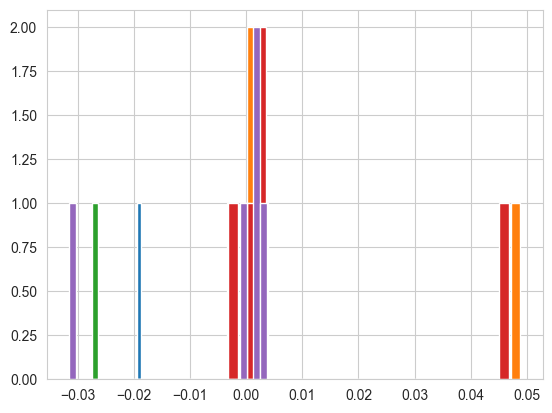

In [136]:
fig, ax = plt.subplots()
for i in range(IA.shape[0]):
    ax.hist(IF[:,i], weights=IA[:,i], label=f'{i}', bins=30)
plt.show()

fig, ax = plt.subplots()
for i in range(IA.shape[0]):
    ax.hist(IF[:,i], label=f'{i}', bins=30)
plt.show()